# 날씨 예측 모형 + 랜덤포레스트

#### 60170029 이종언

In [203]:
import pandas as pd 
import numpy as np
#sklearn 호출
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets

# 1. 데이터 불러오기 & EDA

In [204]:
df = pd.read_csv('weather.csv')
df.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,Yes


In [205]:
# MinTemp : 최저기온
# MaxTemp : 최고기온
# Rainfall : 강우량
# Evaporation : 증발도
# Sunshine : 광량
# WindGustDir : 풍향
# WindGustSpeed : 풍속
# WindDir9am : 오전 9시 풍향
# WindDir3pm : 오후 3시 풍향
# WindSpeed9am : 오전 9시 풍속
# WindSpeed3pm : 오후 3시 풍속
# Humidity9am : 오전 9시 습도
# Humidity3pm : 오후 3시 습도
# Pressure9am : 오전 9시 대기압
# Pressure3pm : 오후 3시 대기압
# Cloud9am : 오전 9시 구름밀집도
# Cloud3pm : 오후 3시 구름밀집도
# Temp9am : 오전 9시 온도
# Temp3pm : 오후 3시 온도
# RainToday : 오늘 강수여부

## 1-1) 데이터 확인

In [206]:
print('Column 수 : %s' % df.shape[0]) #인덱스칼럼도 포함
print('Row 수 : %s' % df.shape[1])
print('\n[데이터프레임 정보]')
df.info() #데이터프레임의 정보 표시

Column 수 : 366
Row 수 : 20

[데이터프레임 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        

In [207]:
df.isnull().sum()

MinTemp           0
MaxTemp           0
Rainfall          0
Evaporation       0
Sunshine          3
WindGustDir       3
WindGustSpeed     2
WindDir9am       31
WindDir3pm        1
WindSpeed9am      7
WindSpeed3pm      0
Humidity9am       0
Humidity3pm       0
Pressure9am       0
Pressure3pm       0
Cloud9am          0
Cloud3pm          0
Temp9am           0
Temp3pm           0
RainToday         0
dtype: int64

#### Sunshine(3개) / WIndGustDir(3개)/ WindGustSpeed(2개) / WindDir9am(31개) / WindDIr3pm(1개) / WindSpeed9am(7개) 의 결측치를 채워야 한다.
#### 
#### 목표변수를 제외한 WindGustDir / WindDir9am / WindDir3am 값은 Object 이기에 매핑을 하거나 인코딩해야하며, 나머지 결측치는 선형 보간법을 이용해 결측치를 채울 것이다.

## 1-2) 데이터 시각화

### 1-2-1) 일반적인 통계 그래프

In [208]:
#plot 라이브러리 호출
import matplotlib.pyplot as plot
#그래프 표시를 위한 문자형 칼럼 제거(문자열 값 인식불가)
dftemp1 = df.drop(['WindGustDir','WindDir9am','WindDir3pm'], axis=1)
dftemp1


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,24.3,0.0,3.4,6.3,30.0,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No
1,14.0,26.9,3.6,4.4,9.7,39.0,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes
2,13.7,23.4,3.6,5.8,3.3,85.0,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes
3,13.3,15.5,39.8,7.2,9.1,54.0,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes
4,7.6,16.1,2.8,5.6,10.6,50.0,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,9.0,30.7,0.0,7.6,12.1,76.0,7.0,50,38,15,1016.1,1010.8,1,3,20.4,30.0,No
362,7.1,28.4,0.0,11.6,12.7,48.0,2.0,19,45,22,1020.0,1016.9,0,1,17.2,28.2,No
363,12.5,19.9,0.0,8.4,5.3,43.0,11.0,9,63,47,1024.0,1022.8,3,2,14.5,18.3,No
364,12.5,26.9,0.0,5.0,7.1,46.0,6.0,28,69,39,1021.0,1016.2,6,7,15.8,25.9,No


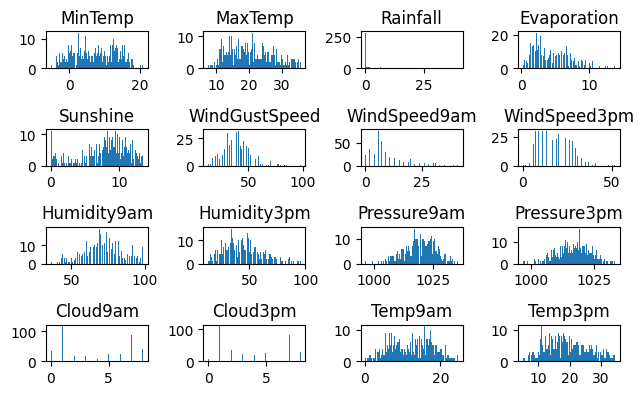

In [209]:
#복수 그래프 출력
for i in range(dftemp1.shape[1]-1): # 목표변수 칼럼 제외
    data = np.array(dftemp1.iloc[:,i]) #각 칼럼의 값들을 Array 에 값 저장
    plot.subplot(5,4,i+1) # 5x4 서브플롯의 index 1부터 1차원 Array 값 입력
    plot.hist(data,bins=100) #히스토그램으로 표시, 100씩 묶음
    plot.title(dftemp1.columns[i]) #각 서브플롯별로 Title 을 df의 칼럼명으로 입력
plot.tight_layout() #서브플롯별로 겹치지 않게 Layout 설정
plot.show()

#### 각 칼럼별로 유니크한 값의 분포 확인

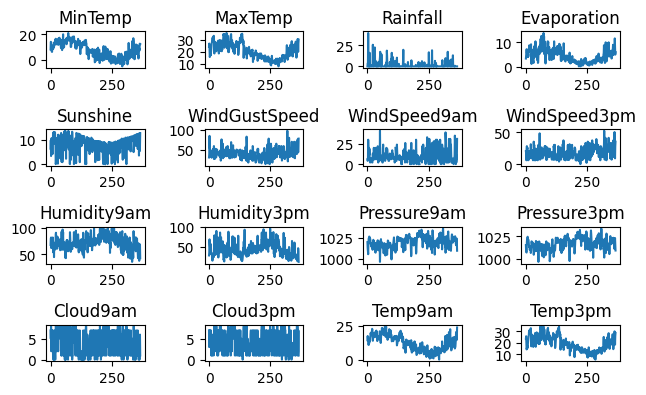

In [210]:
import matplotlib.pyplot as plt
for i in range(dftemp1.shape[1]-1):  # 목표변수 칼럼 제외
    Xval = np.array(dftemp1.index)
    Yval = np.array(dftemp1.iloc[:,i])
    plt.subplot(5,4,i+1)
    plt.plot(Xval, Yval)
    plt.title(dftemp1.columns[i])
plt.tight_layout()
plt.show()

#### Index(시간) 순서에 따른 기온의 변화

## 1-2-2) 목표변수의 비율 확인

['No', 'Yes']
[300, 66]


<BarContainer object of 2 artists>

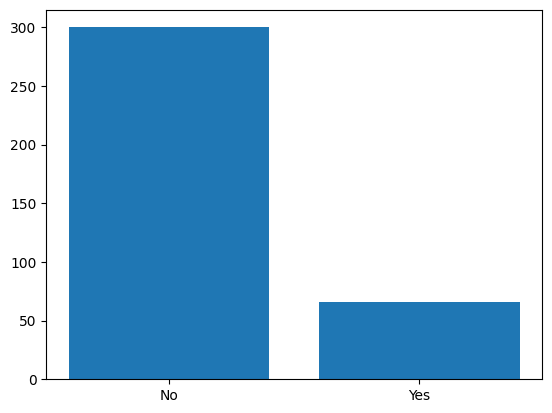

In [211]:
print(df['RainToday'].unique().tolist())
print(df['RainToday'].value_counts().tolist())
## sns countplot 사용가능
plot.bar(df['RainToday'].unique().tolist(), df['RainToday'].value_counts().tolist())

#### 목표변수값의 비율차가 있어 클래스편향이 존재한다. 추후 모델적합 시 SMOTE 모듈로 샘플링이 필요하다.

# 2. 데이터 전처리

## 2-1) 상관계수 분석을 위해 목표변수를 int타입으로 매핑

In [212]:
df['RainToday'] = df.RainToday.map({'Yes':1, 'No':0})
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,0
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,1
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,1
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,1
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,1


## 2-2) 상관계수 분석

In [213]:
import seaborn as sns #seaborn 호출
plot.figure(figsize=(10,5)) #10x5 크기로 설정
#dfcorr = df.corr()
#sns.heatmap(data = dfcorr, annot=True, fmt = '0.2f', cmap='Blues')

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

### 결측치 중
#### Sunshine 변수는 Humidity3pm, Could9am, Cloud3pm 변수와 상관관계가 높았고
#### WindGustSpeed 변수는 WindSpeed3pm, WindSpeed9am, Pressure3pm, Pressure9am 변수와 상관관계가 높았으며
#### WindSpeed9am 변수는 WindGustSpeed, WindSpeed3pm 변수와 상관관계가 높았다.
#### RainToday 변수와 가장 상관관계가 높은 변수는 당연하게도 Rainfall 이였고, 다음으로 Humidity3pm과 Pressure9am이 있었다.

## 2-3) 결측치 채울 방법 탐색

##### Null값이 존재하는 행만 추출

In [214]:
dftemp0 = df[df.isnull( ).any(axis=1)]
dftemp0[['Sunshine','WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am']]

,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am
113,8.6,W,50.0,NaN,W,NaN
118,8.1,W,48.0,NaN,W,NaN
127,7.5,E,50.0,NaN,ENE,NaN
138,10.7,NW,43.0,NaN,WNW,0.0
140,8.0,NW,46.0,NaN,WSW,0.0
174,6.8,ENE,26.0,NaN,ESE,0.0
176,8.9,WNW,22.0,NaN,NW,0.0
180,9.5,NNW,22.0,NaN,NNW,0.0
189,9.4,NW,24.0,NaN,NW,0.0
193,7.7,NaN,24.0,E,NNW,4.0


##### Object 타입인 WIndGustDirs, WindDIr9am, WIndDir3pm는 변수형 데이터이나, 변수가 너무 많아 원핫인코딩을 진행하기에 어려운 부분이 있다.
##### 단, 방위데이터이기에 각도데이터로 수치화하여 매핑할 수 있다.
##### 
##### Sunshine,WindGustSpeed,WindSpeed9am 변수의 경우, 선형보간을 진행하여 공백을 메꿀 것이다.

## 2-3) 수치형 Sunshine, WindGustSpeed, WIndSpeed9am 변수 결측치 선형 보간

In [215]:
df['Sunshine'] = df['Sunshine'].interpolate(method='linear')
df['WindGustSpeed'] = df['WindGustSpeed'].interpolate(method='linear')
df['WindSpeed9am'] = df['WindSpeed9am'].interpolate(method='linear')

## 2-4) 변수형 WindGustDir, WindDir3pm, WindDir9am 칼럼 결측치 보간(이전 행의 값을 가져옴)

In [216]:
df['WindGustDir'].fillna(method='ffill', inplace=True)
df['WindDir3pm'].fillna(method='ffill', inplace=True) 

##### WindDir9am 은 Null값이 전체 레코드의 8%가량이며 WindDir3pm 의 데이터로 충분하다 생각하여 삭제하였다.

In [217]:
df = df.drop('WindDir9am', axis=1)

## 2-5) 비가 조금이라도 오면 RainToday 가 True 가 되도록 변경

In [218]:
df.loc[df['Rainfall'] > 0, 'RainToday'] = 1

In [219]:
df.isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

In [220]:
df.head(10)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,0
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,1
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,1
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,W,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,1
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,ESE,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,1
5,6.2,16.9,0.0,5.8,8.2,SE,44.0,E,20.0,24,70,57,1023.8,1021.7,7,5,10.9,14.8,0
6,6.1,18.2,0.2,4.2,8.4,SE,43.0,ESE,19.0,26,63,47,1024.6,1022.2,4,6,12.4,17.3,1
7,8.3,17.0,0.0,5.6,4.6,E,41.0,E,11.0,24,65,57,1026.2,1024.2,6,7,12.1,15.5,0
8,8.8,19.5,0.0,4.0,4.1,S,48.0,ENE,19.0,17,70,48,1026.1,1022.7,7,7,14.1,18.9,0
9,8.4,22.8,16.2,5.4,7.7,E,31.0,ESE,7.0,6,82,32,1024.1,1020.7,7,1,13.3,21.7,1


## 2-5) 16방위인 방위데이터를 수치형 각도데이터로

In [221]:
df['WindDir3pm'].unique()

array(['NW', 'W', 'NNE', 'ESE', 'E', 'ENE', 'WSW', 'NE', 'NNW', 'SE', 'S',
       'SW', 'WNW', 'N', 'SSW', 'SSE'], dtype=object)

In [222]:
dirmap = {'N':0,'NNE':22.5,'NE':45,'ENE':67.5,'E':90,'ESE':112.5,'SE':135,'SSE':157.5,'S':180,'SSW':202.5,'SW':225,'WSW':247.5,'W':270,'WNW':292.5,'NW':315,'NNW':337.5}
df['WindGustDir'] = df.WindGustDir.map(dirmap)
df['WindDir3pm'] = df.WindDir3pm.map(dirmap)

#### 단, 풍향데이터는 360도와 0도값이 같아야 하므로 sin cos값으로 풍향값을 저장해야 한다.

In [223]:
df.insert(0,"WindGustDir_sin",np.sin(df['WindGustDir']),True)
df.insert(0,"WindGustDir_cos",np.cos(df['WindGustDir']),True)

df.insert(0,"WindDir3pm_sin",np.sin(df['WindDir3pm']),True)
df.insert(0,"WindDir3pm_cos",np.cos(df['WindDir3pm']),True)

df.head()

,WindDir3pm_cos,WindDir3pm_sin,WindGustDir_cos,WindGustDir_sin,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,0.666916,0.745133,0.666916,0.745133,8.0,24.3,0.0,3.4,6.3,315.0,...,20,68,29,1019.7,1015.0,7,7,14.4,23.6,0
1,0.984382,-0.176046,-0.044228,-0.999021,14.0,26.9,3.6,4.4,9.7,67.5,...,17,80,36,1012.4,1008.4,5,3,17.5,25.7,1
2,-0.873305,-0.487175,0.666916,0.745133,13.7,23.4,3.6,5.8,3.3,315.0,...,6,82,69,1009.5,1007.2,8,7,15.4,20.2,1
3,0.984382,-0.176046,0.666916,0.745133,13.3,15.5,39.8,7.2,9.1,315.0,...,24,62,56,1005.5,1007.0,2,7,13.5,14.1,1
4,0.826837,-0.562441,0.912939,0.408096,7.6,16.1,2.8,5.6,10.6,157.5,...,28,68,49,1018.3,1018.5,7,7,11.1,15.4,1


In [224]:
#필요없는 칼럼 제거
df.drop('WindGustDir',axis=1, inplace=True)
df.drop('WindDir3pm',axis=1, inplace=True)
df.columns.tolist()

['WindDir3pm_cos',
 'WindDir3pm_sin',
 'WindGustDir_cos',
 'WindGustDir_sin',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

## 2-6) RainTomorrow 칼럼 추가

#### 보너스 과제 수행을 위해 데이터프레임 백업

In [225]:
df1 = df.copy()

#### RainToday 칼럼의 1부터 끝까지 참조하고, 마지막에 null 값을 추가하여 RainTomorrow 칼럼을 만들기로 했다.

In [226]:
#RainToday 칼럼의 값을 리스트로 만들기
RainTomorrow = df['RainToday'].tolist()
#리스트의 2번째(INDEX 1)부터 끝까지 참조
RainTomorrow = RainTomorrow[1:]

#RainTomorrow List 의 마지막에 Null값 추가
RainTomorrow = RainTomorrow + [None]
df['RainTomorrow'] = RainTomorrow
df

,WindDir3pm_cos,WindDir3pm_sin,WindGustDir_cos,WindGustDir_sin,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.666916,0.745133,0.666916,0.745133,8.0,24.3,0.0,3.4,6.3,30.0,...,68,29,1019.7,1015.0,7,7,14.4,23.6,0,1.0
1,0.984382,-0.176046,-0.044228,-0.999021,14.0,26.9,3.6,4.4,9.7,39.0,...,80,36,1012.4,1008.4,5,3,17.5,25.7,1,1.0
2,-0.873305,-0.487175,0.666916,0.745133,13.7,23.4,3.6,5.8,3.3,85.0,...,82,69,1009.5,1007.2,8,7,15.4,20.2,1,1.0
3,0.984382,-0.176046,0.666916,0.745133,13.3,15.5,39.8,7.2,9.1,54.0,...,62,56,1005.5,1007.0,2,7,13.5,14.1,1,1.0
4,0.826837,-0.562441,0.912939,0.408096,7.6,16.1,2.8,5.6,10.6,50.0,...,68,49,1018.3,1018.5,7,7,11.1,15.4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.666916,0.745133,-0.219411,-0.975633,9.0,30.7,0.0,7.6,12.1,76.0,...,38,15,1016.1,1010.8,1,3,20.4,30.0,0,0.0
362,-0.219411,-0.975633,1.000000,0.000000,7.1,28.4,0.0,11.6,12.7,48.0,...,45,22,1020.0,1016.9,0,1,17.2,28.2,0,0.0
363,-0.044228,-0.999021,0.826837,-0.562441,12.5,19.9,0.0,8.4,5.3,43.0,...,63,47,1024.0,1022.8,3,2,14.5,18.3,0,0.0
364,-0.945430,-0.325824,0.666916,0.745133,12.5,26.9,0.0,5.0,7.1,46.0,...,69,39,1021.0,1016.2,6,7,15.8,25.9,0,0.0


In [227]:
#RainTomorrow 값이 없는 마지막날 데이터 제거
df.dropna(subset=['RainTomorrow'], axis = 0, inplace = True)

In [228]:
#특정 칼럼 제외하고 array 에 넣기(loc 함수 사용)
X = np.array(df.loc[:,[i for i in list(df.columns) if i not in ['RainTomorrow']]]) 
Y = np.array(df['RainTomorrow'])

In [229]:
X

array([[ 0.6669156 ,  0.74513326,  0.6669156 , ..., 14.4       ,
        23.6       ,  0.        ],
       [ 0.98438195, -0.17604595, -0.04422762, ..., 17.5       ,
        25.7       ,  1.        ],
       [-0.87330464, -0.48717451,  0.6669156 , ..., 15.4       ,
        20.2       ,  1.        ],
       ...,
       [-0.21941055, -0.97563262,  1.        , ..., 17.2       ,
        28.2       ,  0.        ],
       [-0.04422762, -0.99902148,  0.82683716, ..., 14.5       ,
        18.3       ,  0.        ],
       [-0.94543042, -0.32582405,  0.6669156 , ..., 15.8       ,
        25.9       ,  0.        ]])

In [230]:
Y

array([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0.

# 3. 모델적합

## 3-1) 속성과 목표변수값 분리

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

## 3-2) 모델적합 이전에 SMOTE 모듈로 샘플림  

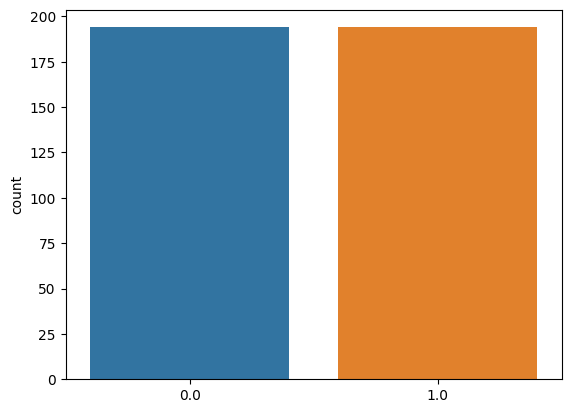

In [232]:
from imblearn.over_sampling import SMOTE
#SMOTE 객체 생성
sm = SMOTE(random_state=0)
#X,Y값을 리샘플링
X_train_balanced, Y_train_balanced = sm.fit_resample(X_train,Y_train)

#countplot 표시
import seaborn as sns
sns.countplot(x=Y_train_balanced)

#의사결정나무 모델 라이브러리 호출
from sklearn.tree import DecisionTreeClassifier



In [233]:
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train_balanced, Y_train_balanced)
tree_pred=tree.predict(X_test)

In [234]:
print(classification_report(Y_test, tree.predict(X_test)))
print(confusion_matrix(Y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.86      0.63      0.73        68
         1.0       0.40      0.71      0.52        24

    accuracy                           0.65        92
   macro avg       0.63      0.67      0.62        92
weighted avg       0.74      0.65      0.67        92

[[43 25]
 [ 7 17]]


# 3-3) 트리 깊이에 따른 정확도 분석

In [235]:
train_scores, test_scores = list(), list()
for i in range(1,20):
    DT = DecisionTreeClassifier(max_depth=i, random_state=0)
    DT.fit(X_train_balanced, Y_train_balanced)
    
    #정확도 평가
    train_att = DT.predict(X_train)
    train_acc = accuracy_score(Y_train, train_att)
    train_scores.append(train_acc) #train_acc를 train_scores 에 추가
    
    # 테스트 데이터셋 정확도 평가
    test_att = DT.predict(X_test)
    test_acc = accuracy_score(Y_test, test_att)
    test_scores.append(test_acc)
    
    #depth 개수에 따른 정확도 차이 확인
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    

>1, train: 0.648, test: 0.576
>2, train: 0.656, test: 0.587
>3, train: 0.733, test: 0.641
>4, train: 0.795, test: 0.620
>5, train: 0.828, test: 0.652
>6, train: 0.857, test: 0.663
>7, train: 0.905, test: 0.674
>8, train: 0.949, test: 0.685
>9, train: 0.967, test: 0.674
>10, train: 0.985, test: 0.685
>11, train: 0.989, test: 0.696
>12, train: 1.000, test: 0.663
>13, train: 1.000, test: 0.663
>14, train: 1.000, test: 0.663
>15, train: 1.000, test: 0.663
>16, train: 1.000, test: 0.663
>17, train: 1.000, test: 0.663
>18, train: 1.000, test: 0.663
>19, train: 1.000, test: 0.663


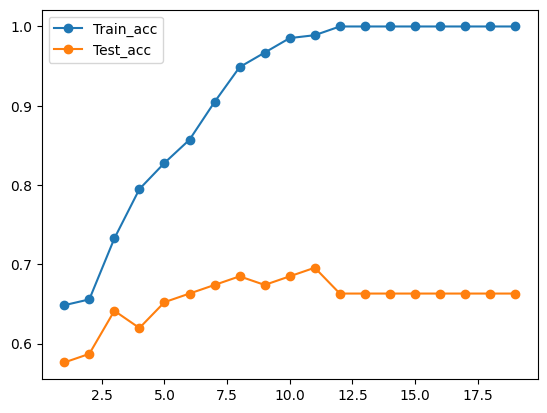

In [236]:
from matplotlib import pyplot
pyplot.plot(range(1,20), train_scores, '-o', label='Train_acc')
pyplot.plot(range(1,20), test_scores, '-o', label='Test_acc')
#pyplot 의 legend 
pyplot.legend()
pyplot.show()

### 의사결정나무 최대 깊이를 1으로 설정하였다.

# 4.모델 평가

In [237]:
tree = DecisionTreeClassifier(max_depth=11, random_state=0)
tree.fit(X_train_balanced, Y_train_balanced)
print(classification_report(Y_test, tree.predict(X_test)))
print(confusion_matrix(Y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.84      0.72      0.78        68
         1.0       0.44      0.62      0.52        24

    accuracy                           0.70        92
   macro avg       0.64      0.67      0.65        92
weighted avg       0.74      0.70      0.71        92

[[49 19]
 [ 9 15]]


##### 정확도가 65%에서 70%로 상승하였고, 정밀도와 재현율에는 약간의 상승이 있었다.

## 4-1) 변수 중요도

In [238]:
df_im = pd.DataFrame(tree.feature_importances_.reshape(1,-1), columns=df.columns[:-1], index=['feature_importance'])
df_im

,WindDir3pm_cos,WindDir3pm_sin,WindGustDir_cos,WindGustDir_sin,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
feature_importance,0.080691,0.034343,0.009955,0.0,0.003012,0.007027,0.019161,0.010409,0.079331,0.088741,...,0.019033,0.048613,0.036594,0.0,0.127625,0.028695,0.266925,0.05658,0.043879,0.0


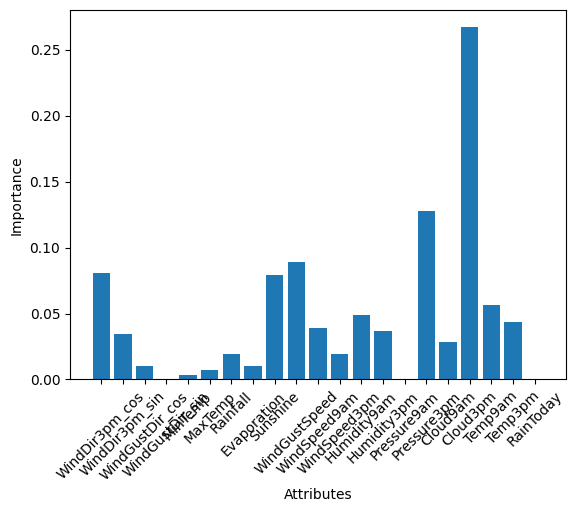

In [239]:
plot.bar(df_im.columns, df_im.loc['feature_importance'])
plot.xlabel('Attributes')
plot.ylabel('Importance')
plot.xticks(rotation=45) #라벨이 겹쳐서 각도 변경
plot.show()

#### 강수여부는 오전 9시에 구름량과, 오전 9시의 기압에 큰 영향을 받는 것으로 보인다.

## 4-2) ROC 커브

In [240]:
tree.predict_proba(X_test)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

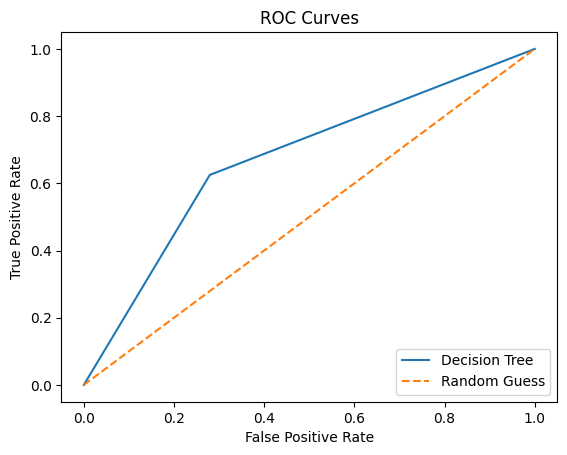

In [241]:
from sklearn.metrics import roc_curve
#fpr 이 X값, tpr 이 Y값
# FPR : 잘못맞춤, 진짜라고, 그 비율
# TPR : 잘 맞춤, 진짜라고, 그 비율
fpr, tpr, thresholds = roc_curve(Y_test, tree.predict_proba(X_test)[:,1])

#ROC Curve 그래프 그리기
from matplotlib import pyplot as plt

#fpr 을 X축, tpr 를 Y축으로 그림
plt.plot(fpr, tpr, '-', ms=2, label="Decision Tree")
#랜덤으로 맞출 때(ROC가 0.5)일대
plt.plot([0,1],[0,1], '--', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [242]:
#AUC 계산
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
print('Area Under Curve : %0.2f' % roc_auc)

Area Under Curve : 0.67


#### 이 모델은 FPR(진짜라고 잘못 판단한 비율)의 증가량보다 TPR(진짜라고 맞게 판단한 비율)의 증가량이 더 크므로 랜덤으로 맞춘 것보다 좋은 모델이라 할 수 있다.

## 4-3) 의사결정나무 시각화

In [243]:
fname = df.columns.tolist()
#목표변수칼럼 제거
fname.remove('RainTomorrow')
fname

['WindDir3pm_cos',
 'WindDir3pm_sin',
 'WindGustDir_cos',
 'WindGustDir_sin',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

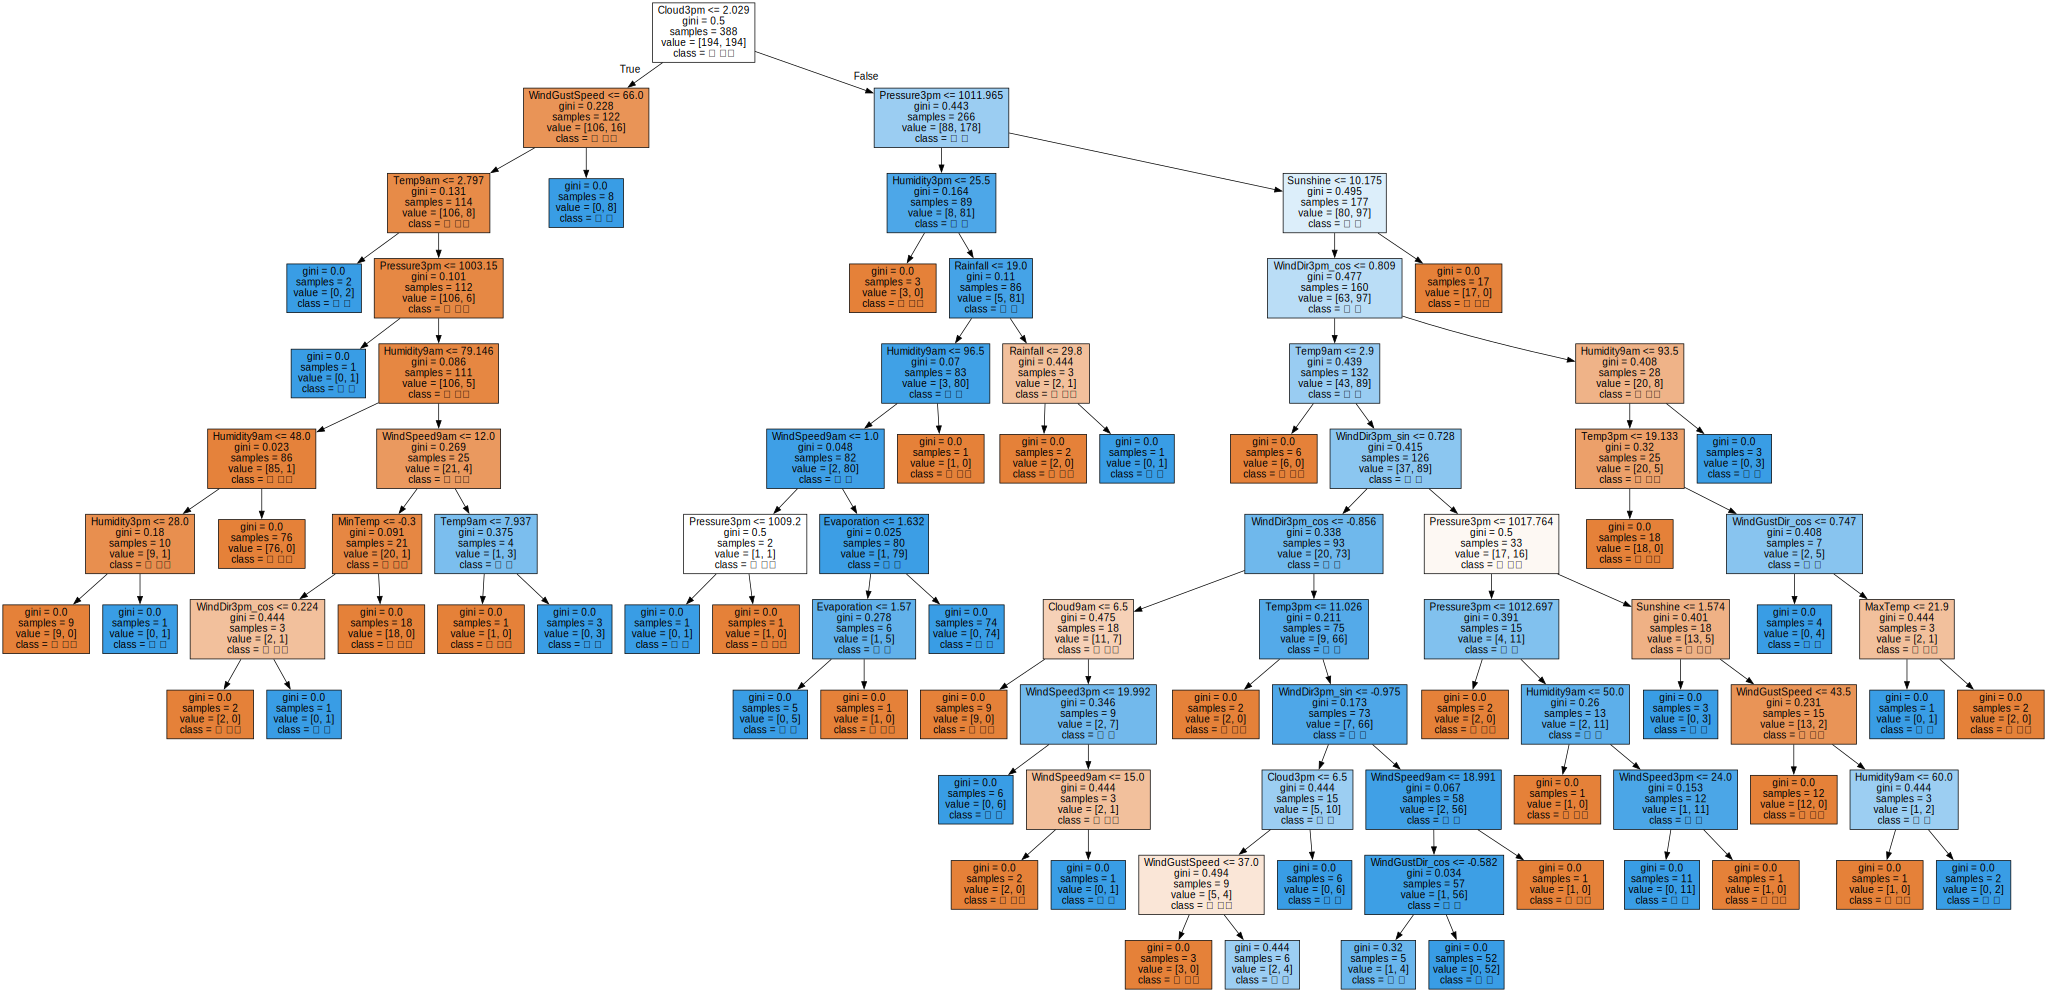

In [244]:
import graphviz
from sklearn.tree import export_graphviz

tree_graph = export_graphviz(tree, feature_names=fname,
                             class_names=['비 안옴','비 옴'], filled=True)
graphviz.Source(tree_graph)

In [245]:
dot = graphviz.Source(tree_graph)
dot.format = 'png'
dot.render(filename='weather_tomorrow_tree', directory='tree', cleanup=True)

'tree\\weather_tomorrow_tree.png'

# 추가과제 ) 모레도 비가 올까 ?

## A1) 다음날 비가 올지 여부를 담는 칼럼 추가

In [246]:
df1.head()

,WindDir3pm_cos,WindDir3pm_sin,WindGustDir_cos,WindGustDir_sin,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,0.666916,0.745133,0.666916,0.745133,8.0,24.3,0.0,3.4,6.3,30.0,...,20,68,29,1019.7,1015.0,7,7,14.4,23.6,0
1,0.984382,-0.176046,-0.044228,-0.999021,14.0,26.9,3.6,4.4,9.7,39.0,...,17,80,36,1012.4,1008.4,5,3,17.5,25.7,1
2,-0.873305,-0.487175,0.666916,0.745133,13.7,23.4,3.6,5.8,3.3,85.0,...,6,82,69,1009.5,1007.2,8,7,15.4,20.2,1
3,0.984382,-0.176046,0.666916,0.745133,13.3,15.5,39.8,7.2,9.1,54.0,...,24,62,56,1005.5,1007.0,2,7,13.5,14.1,1
4,0.826837,-0.562441,0.912939,0.408096,7.6,16.1,2.8,5.6,10.6,50.0,...,28,68,49,1018.3,1018.5,7,7,11.1,15.4,1


In [247]:
#RainToday 칼럼의 값을 리스트로 만들기
Rain2DayAfter = df1['RainToday'].tolist()
#리스트의 2번째(INDEX 1)부터 끝까지 참조
Rain2DayAfter = Rain2DayAfter[2:]

#RainTomorrow List 의 마지막에 Null값 추가
Rain2DayAfter = Rain2DayAfter + [None] * 2
df1['Rain2DayAfter'] = Rain2DayAfter
df1.head(20)

,WindDir3pm_cos,WindDir3pm_sin,WindGustDir_cos,WindGustDir_sin,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Rain2DayAfter
0,0.666916,0.745133,0.666916,0.745133,8.0,24.3,0.0,3.4,6.3,30.0,...,68,29,1019.7,1015.0,7,7,14.4,23.6,0,1.0
1,0.984382,-0.176046,-0.044228,-0.999021,14.0,26.9,3.6,4.4,9.7,39.0,...,80,36,1012.4,1008.4,5,3,17.5,25.7,1,1.0
2,-0.873305,-0.487175,0.666916,0.745133,13.7,23.4,3.6,5.8,3.3,85.0,...,82,69,1009.5,1007.2,8,7,15.4,20.2,1,1.0
3,0.984382,-0.176046,0.666916,0.745133,13.3,15.5,39.8,7.2,9.1,54.0,...,62,56,1005.5,1007.0,2,7,13.5,14.1,1,0.0
4,0.826837,-0.562441,0.912939,0.408096,7.6,16.1,2.8,5.6,10.6,50.0,...,68,49,1018.3,1018.5,7,7,11.1,15.4,1,1.0
5,-0.448074,0.893997,-0.996088,0.088369,6.2,16.9,0.0,5.8,8.2,44.0,...,70,57,1023.8,1021.7,7,5,10.9,14.8,0,0.0
6,0.826837,-0.562441,-0.996088,0.088369,6.1,18.2,0.2,4.2,8.4,43.0,...,63,47,1024.6,1022.2,4,6,12.4,17.3,1,0.0
7,-0.448074,0.893997,-0.448074,0.893997,8.3,17.0,0.0,5.6,4.6,41.0,...,65,57,1026.2,1024.2,6,7,12.1,15.5,0,1.0
8,-0.044228,-0.999021,-0.598460,-0.801153,8.8,19.5,0.0,4.0,4.1,48.0,...,70,48,1026.1,1022.7,7,7,14.1,18.9,0,0.0
9,0.826837,-0.562441,-0.448074,0.893997,8.4,22.8,16.2,5.4,7.7,31.0,...,82,32,1024.1,1020.7,7,1,13.3,21.7,1,1.0


In [270]:
df1.tail(3)

,WindDir3pm_cos,WindDir3pm_sin,WindGustDir_cos,WindGustDir_sin,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Rain2DayAfter
361,0.666916,0.745133,-0.219411,-0.975633,9.0,30.7,0.0,7.6,12.1,76.0,...,38,15,1016.1,1010.8,1,3,20.4,30.0,0,0.0
362,-0.219411,-0.975633,1.000000,0.000000,7.1,28.4,0.0,11.6,12.7,48.0,...,45,22,1020.0,1016.9,0,1,17.2,28.2,0,0.0
363,-0.044228,-0.999021,0.826837,-0.562441,12.5,19.9,0.0,8.4,5.3,43.0,...,63,47,1024.0,1022.8,3,2,14.5,18.3,0,0.0


In [248]:
#Rain2DayAfter 값이 없는 마지막날 데이터 제거
df1.dropna(subset=['Rain2DayAfter'], axis = 0, inplace = True)

## A2) 모델적합 및 SMOTE 샘플링

In [249]:
X = np.array(df1.loc[:,[i for i in list(df1.columns) if i not in ['Rain2DayAfter']]]) 
Y = np.array(df1['Rain2DayAfter'])

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

#SMOTE 샘플링
from imblearn.over_sampling import SMOTE
#SMOTE 객체 생성
sm = SMOTE(random_state=0)
#X,Y값을 리샘플링
X_train_sampled, Y_train_sampled = sm.fit_resample(X_train,Y_train)
#의사결정나무 모델 라이브러리 호출
from sklearn.tree import DecisionTreeClassifier
#모델적합
tree2 = DecisionTreeClassifier(max_depth=5, random_state=0)
tree2.fit(X_train_balanced, Y_train_balanced)

DecisionTreeClassifier(max_depth=5, random_state=0)

## A3) 모델 평가

In [251]:
print(classification_report(Y_test, tree2.predict(X_test)))
print(confusion_matrix(Y_test, tree2.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        63
         1.0       0.38      0.54      0.44        28

    accuracy                           0.58        91
   macro avg       0.56      0.57      0.55        91
weighted avg       0.63      0.58      0.60        91

[[38 25]
 [13 15]]


In [252]:
train_scores, test_scores = list(), list()
for i in range(1,20):
    DT = DecisionTreeClassifier(max_depth=i, random_state=0)
    DT.fit(X_train_sampled, Y_train_sampled)
    
    #정확도 평가
    train_att = DT.predict(X_train)
    train_acc = accuracy_score(Y_train, train_att)
    train_scores.append(train_acc) #train_acc를 train_scores 에 추가
    
    # 테스트 데이터셋 정확도 평가
    test_att = DT.predict(X_test)
    test_acc = accuracy_score(Y_test, test_att)
    test_scores.append(test_acc)
    
    #depth 개수에 따른 정확도 차이 확인
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    

>1, train: 0.480, test: 0.451
>2, train: 0.575, test: 0.473
>3, train: 0.575, test: 0.429
>4, train: 0.773, test: 0.549
>5, train: 0.747, test: 0.527
>6, train: 0.802, test: 0.505
>7, train: 0.875, test: 0.505
>8, train: 0.916, test: 0.495
>9, train: 0.949, test: 0.549
>10, train: 0.974, test: 0.549
>11, train: 0.993, test: 0.593
>12, train: 0.996, test: 0.582
>13, train: 1.000, test: 0.593
>14, train: 1.000, test: 0.593
>15, train: 1.000, test: 0.593
>16, train: 1.000, test: 0.593
>17, train: 1.000, test: 0.593
>18, train: 1.000, test: 0.593
>19, train: 1.000, test: 0.593


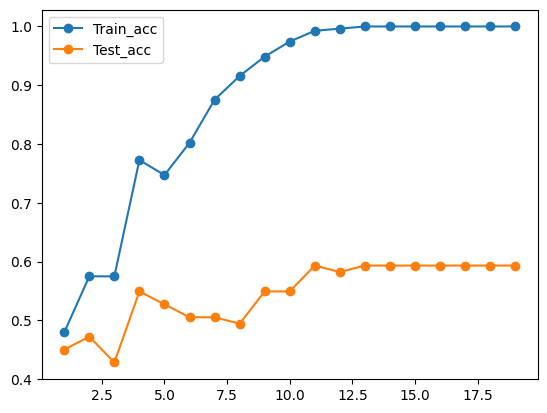

In [253]:
from matplotlib import pyplot
pyplot.plot(range(1,20), train_scores, '-o', label='Train_acc')
pyplot.plot(range(1,20), test_scores, '-o', label='Test_acc')
#pyplot 의 legend 
pyplot.legend()
pyplot.show()

## A4) 모델 재적합 및 평가

In [254]:
tree2 = DecisionTreeClassifier(max_depth=11, random_state=0)
tree2.fit(X_train_sampled, Y_train_sampled)

DecisionTreeClassifier(max_depth=11, random_state=0)

In [255]:
print(classification_report(Y_test, tree2.predict(X_test)))
print(confusion_matrix(Y_test, tree2.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.72      0.67      0.69        63
         1.0       0.36      0.43      0.39        28

    accuracy                           0.59        91
   macro avg       0.54      0.55      0.54        91
weighted avg       0.61      0.59      0.60        91

[[42 21]
 [16 12]]


##### 모레의 강수여부를 예측하는 모델의 정확도는 내일을 예측하는 모델보다 10% 정확도가 떨어지고 재현율과 정밀도가 10~12% 정도 감소하였다.

## A5) AUC값 측정 및 평가

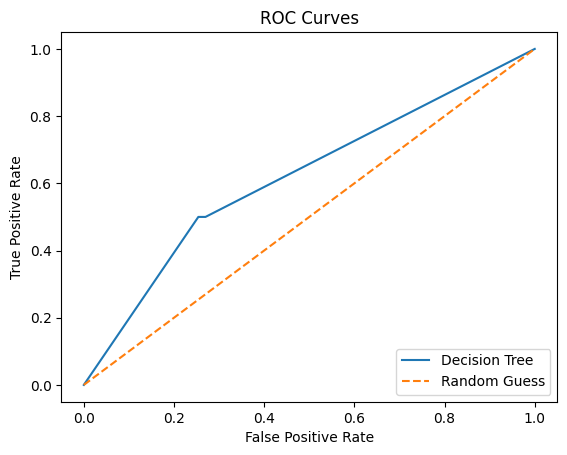

In [256]:
from sklearn.metrics import roc_curve
#fpr 이 X값, tpr 이 Y값
# FPR : 잘못맞춤, 진짜라고, 그 비율
# TPR : 잘 맞춤, 진짜라고, 그 비율
fpr, tpr, thresholds = roc_curve(Y_test, tree.predict_proba(X_test)[:,1])

#ROC Curve 그래프 그리기
from matplotlib import pyplot as plt

#fpr 을 X축, tpr 를 Y축으로 그림
plt.plot(fpr, tpr, '-', ms=2, label="Decision Tree")
#랜덤으로 맞출 때(ROC가 0.5)일대
plt.plot([0,1],[0,1], '--', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [257]:
#AUC 계산
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
print('Area Under Curve : %0.2f' % roc_auc)

Area Under Curve : 0.62


### 모레의 강수여부를 예측하는 모델의 경우 AUC가 0.61로 나와 내일의 강수여부를 예측하는 모델에 비해 성능이 떨어지는 것을 볼 수 있다.

# RandomForest 모델 작성(모레 비가 올지 예측)

##### 모레 배가 올지 예측하는 RandomForest 모델을 작성하였다.

In [258]:
from sklearn.ensemble import RandomForestClassifier
RF1 = RandomForestClassifier(n_estimators = 100, random_state = 0)
#n_estimators : 사용할 tree의 갯수

# B1 모델적합

In [259]:
#모델 적합
RF1.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

# B2 성능평가

In [260]:
#성능평가
RF1_pred = RF1.predict(X_test)

In [261]:
from sklearn.metrics import precision_score, recall_score, f1_score

#정확도 계산 메소드
print('정확도: %0.3f' % accuracy_score(Y_test, RF1_pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF1_pred))
print('재현율: %0.3f' % recall_score(Y_test, RF1_pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF1_pred))
#print(classification_report(Y_test, tree.predict(X_test)))

정확도: 0.626
정밀도: 0.200
재현율: 0.071
f1-score: 0.105


#### SMOTE + 랜덤포레스트 모델의 성능은 위와 같이 나왔다.

# B2-1 최적 나무수 탐색

In [262]:
#정확도 점수 저장할 리스트 생성
scores = []
#1~100까지 수행(5씩 증가)
for i in range(10,100,5):
    #i 변수 지정
    RF = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF.fit(X_train, Y_train)
    RF_pred = RF.predict(X_test)
    res = accuracy_score(Y_test, RF_pred)
    scores.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

> 나무수 : 10, 정확도: 0.648
> 나무수 : 15, 정확도: 0.615
> 나무수 : 20, 정확도: 0.637
> 나무수 : 25, 정확도: 0.615
> 나무수 : 30, 정확도: 0.637
> 나무수 : 35, 정확도: 0.648
> 나무수 : 40, 정확도: 0.648
> 나무수 : 45, 정확도: 0.637
> 나무수 : 50, 정확도: 0.659
> 나무수 : 55, 정확도: 0.626
> 나무수 : 60, 정확도: 0.648
> 나무수 : 65, 정확도: 0.648
> 나무수 : 70, 정확도: 0.637
> 나무수 : 75, 정확도: 0.637
> 나무수 : 80, 정확도: 0.637
> 나무수 : 85, 정확도: 0.637
> 나무수 : 90, 정확도: 0.615
> 나무수 : 95, 정확도: 0.615


# B2-2 나무 숫자에 따른 결과값 시각화

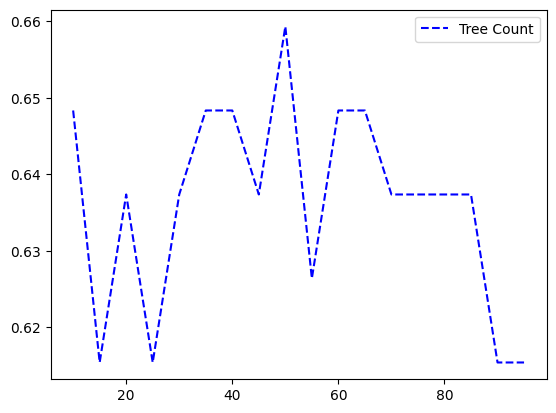

In [263]:
import matplotlib.pyplot as plot
plot.plot(range(10, 100, 5), scores, 'b--', label='Tree Count')
plot.legend()

##### 랜덤포레스트 모델의 최적 나무 수는 약 50개이다.

# B2-3 최적 나무 수로 새로 학습

In [264]:
RF2 = RandomForestClassifier(n_estimators=50, random_state=0)
RF2.fit(X_train, Y_train)
RF2_pred = RF2.predict(X_test)

## 추가) SMOTE 밸런싱 랜덤포레스트 모델 생성

In [265]:
for i in range(10,100,5):
    #i 변수 지정
    RF3 = RandomForestClassifier(n_estimators=i, random_state=0)
    #모델 적합
    RF3.fit(X_train_sampled, Y_train_sampled)
    RF3_pred = RF3.predict(X_test)
    res = accuracy_score(Y_test, RF3_pred)
    scores.append(res)
    
    print('> 나무수 : %d, 정확도: %.3f' %(i, res))

> 나무수 : 10, 정확도: 0.615
> 나무수 : 15, 정확도: 0.593
> 나무수 : 20, 정확도: 0.582
> 나무수 : 25, 정확도: 0.582
> 나무수 : 30, 정확도: 0.571
> 나무수 : 35, 정확도: 0.571
> 나무수 : 40, 정확도: 0.571
> 나무수 : 45, 정확도: 0.582
> 나무수 : 50, 정확도: 0.582
> 나무수 : 55, 정확도: 0.593
> 나무수 : 60, 정확도: 0.582
> 나무수 : 65, 정확도: 0.571
> 나무수 : 70, 정확도: 0.571
> 나무수 : 75, 정확도: 0.571
> 나무수 : 80, 정확도: 0.604
> 나무수 : 85, 정확도: 0.615
> 나무수 : 90, 정확도: 0.604
> 나무수 : 95, 정확도: 0.615


#### SMOTE 랜덤포레스트 최적 깊이는 70~ 이다.

In [266]:
RF3 = RandomForestClassifier(n_estimators=10, random_state=0)
RF3.fit(X_train_sampled, Y_train_sampled)
RF3_pred = RF3.predict(X_test)

# B2-3 조절된 랜덤포레스트 모델 평가

##### 모든 모델은 밸런싱 이전 변수값으로 학습하였다.

In [267]:
#의사결정나무 모델 생성
tree2 = DecisionTreeClassifier(max_depth=8, random_state=0)
tree2.fit(X_train, Y_train)
tree2_pred = tree2.predict(X_test)

In [268]:
print('최적 깊이 의사결정나무 모델\n')
print('정확도: %0.3f' % accuracy_score(Y_test, tree2_pred))
print('정밀도: %0.3f' % precision_score(Y_test, tree2_pred))
print('재현율: %0.3f' % recall_score(Y_test, tree2_pred))
print('f1-score: %0.3f' % f1_score(Y_test, tree2_pred))


print('초기 랜덤포레스트 모델\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF1_pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF1_pred))
print('재현율: %0.3f' % recall_score(Y_test, RF1_pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF1_pred))

print('')

print('최적 나무 수 랜덤포레스트 모델\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF2_pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF2_pred))
print('재현율: %0.3f' % recall_score(Y_test, RF2_pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF2_pred))

print('')

print('최적 나무 수 + SMOTE + 랜덤포레스트 모델\n')
print('정확도: %0.3f' % accuracy_score(Y_test, RF3_pred))
print('정밀도: %0.3f' % precision_score(Y_test, RF3_pred))
print('재현율: %0.3f' % recall_score(Y_test, RF3_pred))
print('f1-score: %0.3f' % f1_score(Y_test, RF3_pred))

최적 깊이 의사결정나무 모델

정확도: 0.659
정밀도: 0.435
재현율: 0.357
f1-score: 0.392
초기 랜덤포레스트 모델

정확도: 0.626
정밀도: 0.200
재현율: 0.071
f1-score: 0.105

최적 나무 수 랜덤포레스트 모델

정확도: 0.659
정밀도: 0.385
재현율: 0.179
f1-score: 0.244

최적 나무 수 + SMOTE + 랜덤포레스트 모델

정확도: 0.615
정밀도: 0.316
재현율: 0.214
f1-score: 0.255


# ROC 커브 그리기

Primal DT AUC : 0.575
Primal RandomForest AUC : 0.517
Optimal RandomForest AUC : 0.523
SMOTE Optimal RandomForest AUC : 0.543


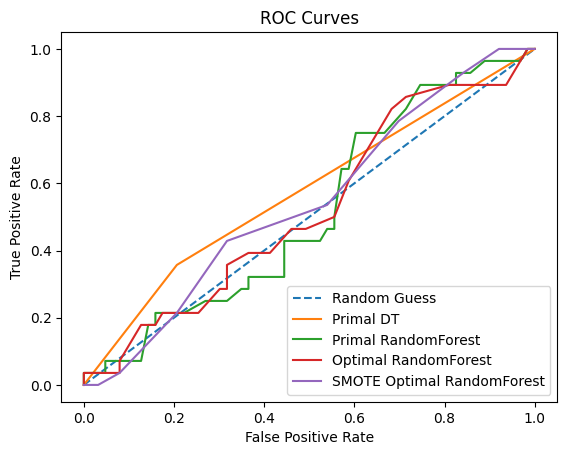

In [269]:
from sklearn.metrics import roc_curve
#fpr 이 X값, tpr 이 Y값
# FPR : 잘못맞춤, 진짜라고, 그 비율
# TPR : 잘 맞춤, 진짜라고, 그 비율
fpr, tpr, thresholds = roc_curve(Y_test, tree.predict_proba(X_test)[:,1])

#ROC Curve 그래프 그리기
from matplotlib import pyplot as plt1

#AUC 측정 라이브러리 호출
from sklearn import metrics

#랜덤으로 맞출 때 그래프 추가
plt1.plot([0,1],[0,1], '--', label = 'Random Guess')

#초기 의사결정나무 모델
fpr, tpr, thresholds = roc_curve(Y_test, tree2.predict_proba(X_test)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="Primal DT")
roc_auc = metrics.auc(fpr, tpr)
print('Primal DT AUC : %0.3f' % roc_auc)

#초기 랜덤포레스트 모델
fpr, tpr, thresholds = roc_curve(Y_test, RF1.predict_proba(X_test)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="Primal RandomForest")
roc_auc = metrics.auc(fpr, tpr)
print('Primal RandomForest AUC : %0.3f' % roc_auc)

#최적 랜덤포레스트 모델 
fpr, tpr, thresholds = roc_curve(Y_test, RF2.predict_proba(X_test)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="Optimal RandomForest")
roc_auc = metrics.auc(fpr, tpr)
print('Optimal RandomForest AUC : %0.3f' % roc_auc)

#최적 SMOTE 랜덤포레스트 모델 
fpr, tpr, thresholds = roc_curve(Y_test, RF3.predict_proba(X_test)[:,1])
plt1.plot(fpr, tpr, '-', ms=2, label="SMOTE Optimal RandomForest")
roc_auc = metrics.auc(fpr, tpr)
print('SMOTE Optimal RandomForest AUC : %0.3f' % roc_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()